# 문제1 - 회귀분석
문제)  
목표변수 FAT를 예측하기 위한 파생변수(BMI 등)를 생성하여 회귀분석을
실시하고 결과를 해석하라.(BMI 계산 시, WEIGHT는 파운드(1lb🡪0.45kg), HEIGHT는
인치(1inch🡪2.54cm)이므로 변환하여 사용)

데이터 : 체질검사.CSV(변수: 14, 자료 수: 252개)

# 스텝0 - 패키지 불러오기

In [72]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.formula.api as smf

# 스텝1 - 데이터 구성하기

In [53]:
df_body = pd.read_csv(path + '체질검사.csv')
df_body.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [59]:
# 파생변수 생성하기
df_body['BMI'] = (df_body['WEIGHT']*0.45)/((df_body['HEIGHT']*2.54)**2)

# 스텝2- 변수간의 경향성 파악

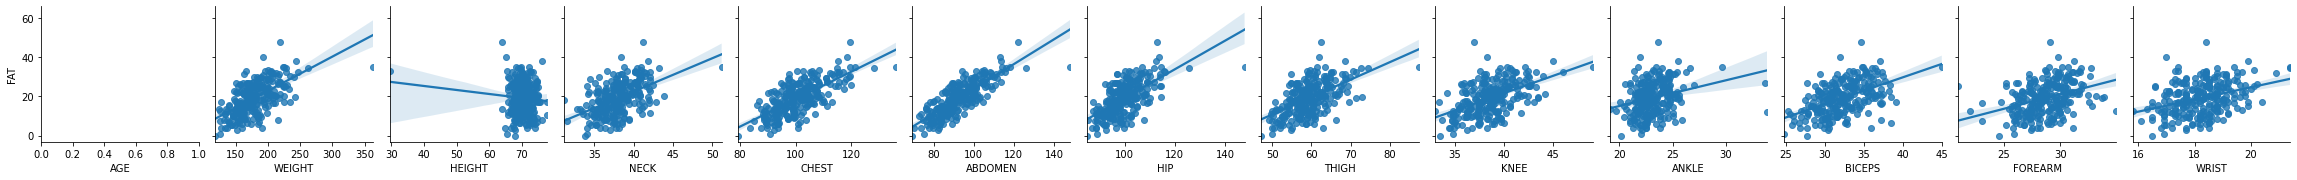

In [66]:
sns.pairplot(df_body, y_vars = 'FAT', x_vars = ['AGE','WEIGHT','HEIGHT','NECK','CHEST','ABDOMEN','HIP','THIGH','KNEE','ANKLE','BICEPS','FOREARM','WRIST'], kind='reg')

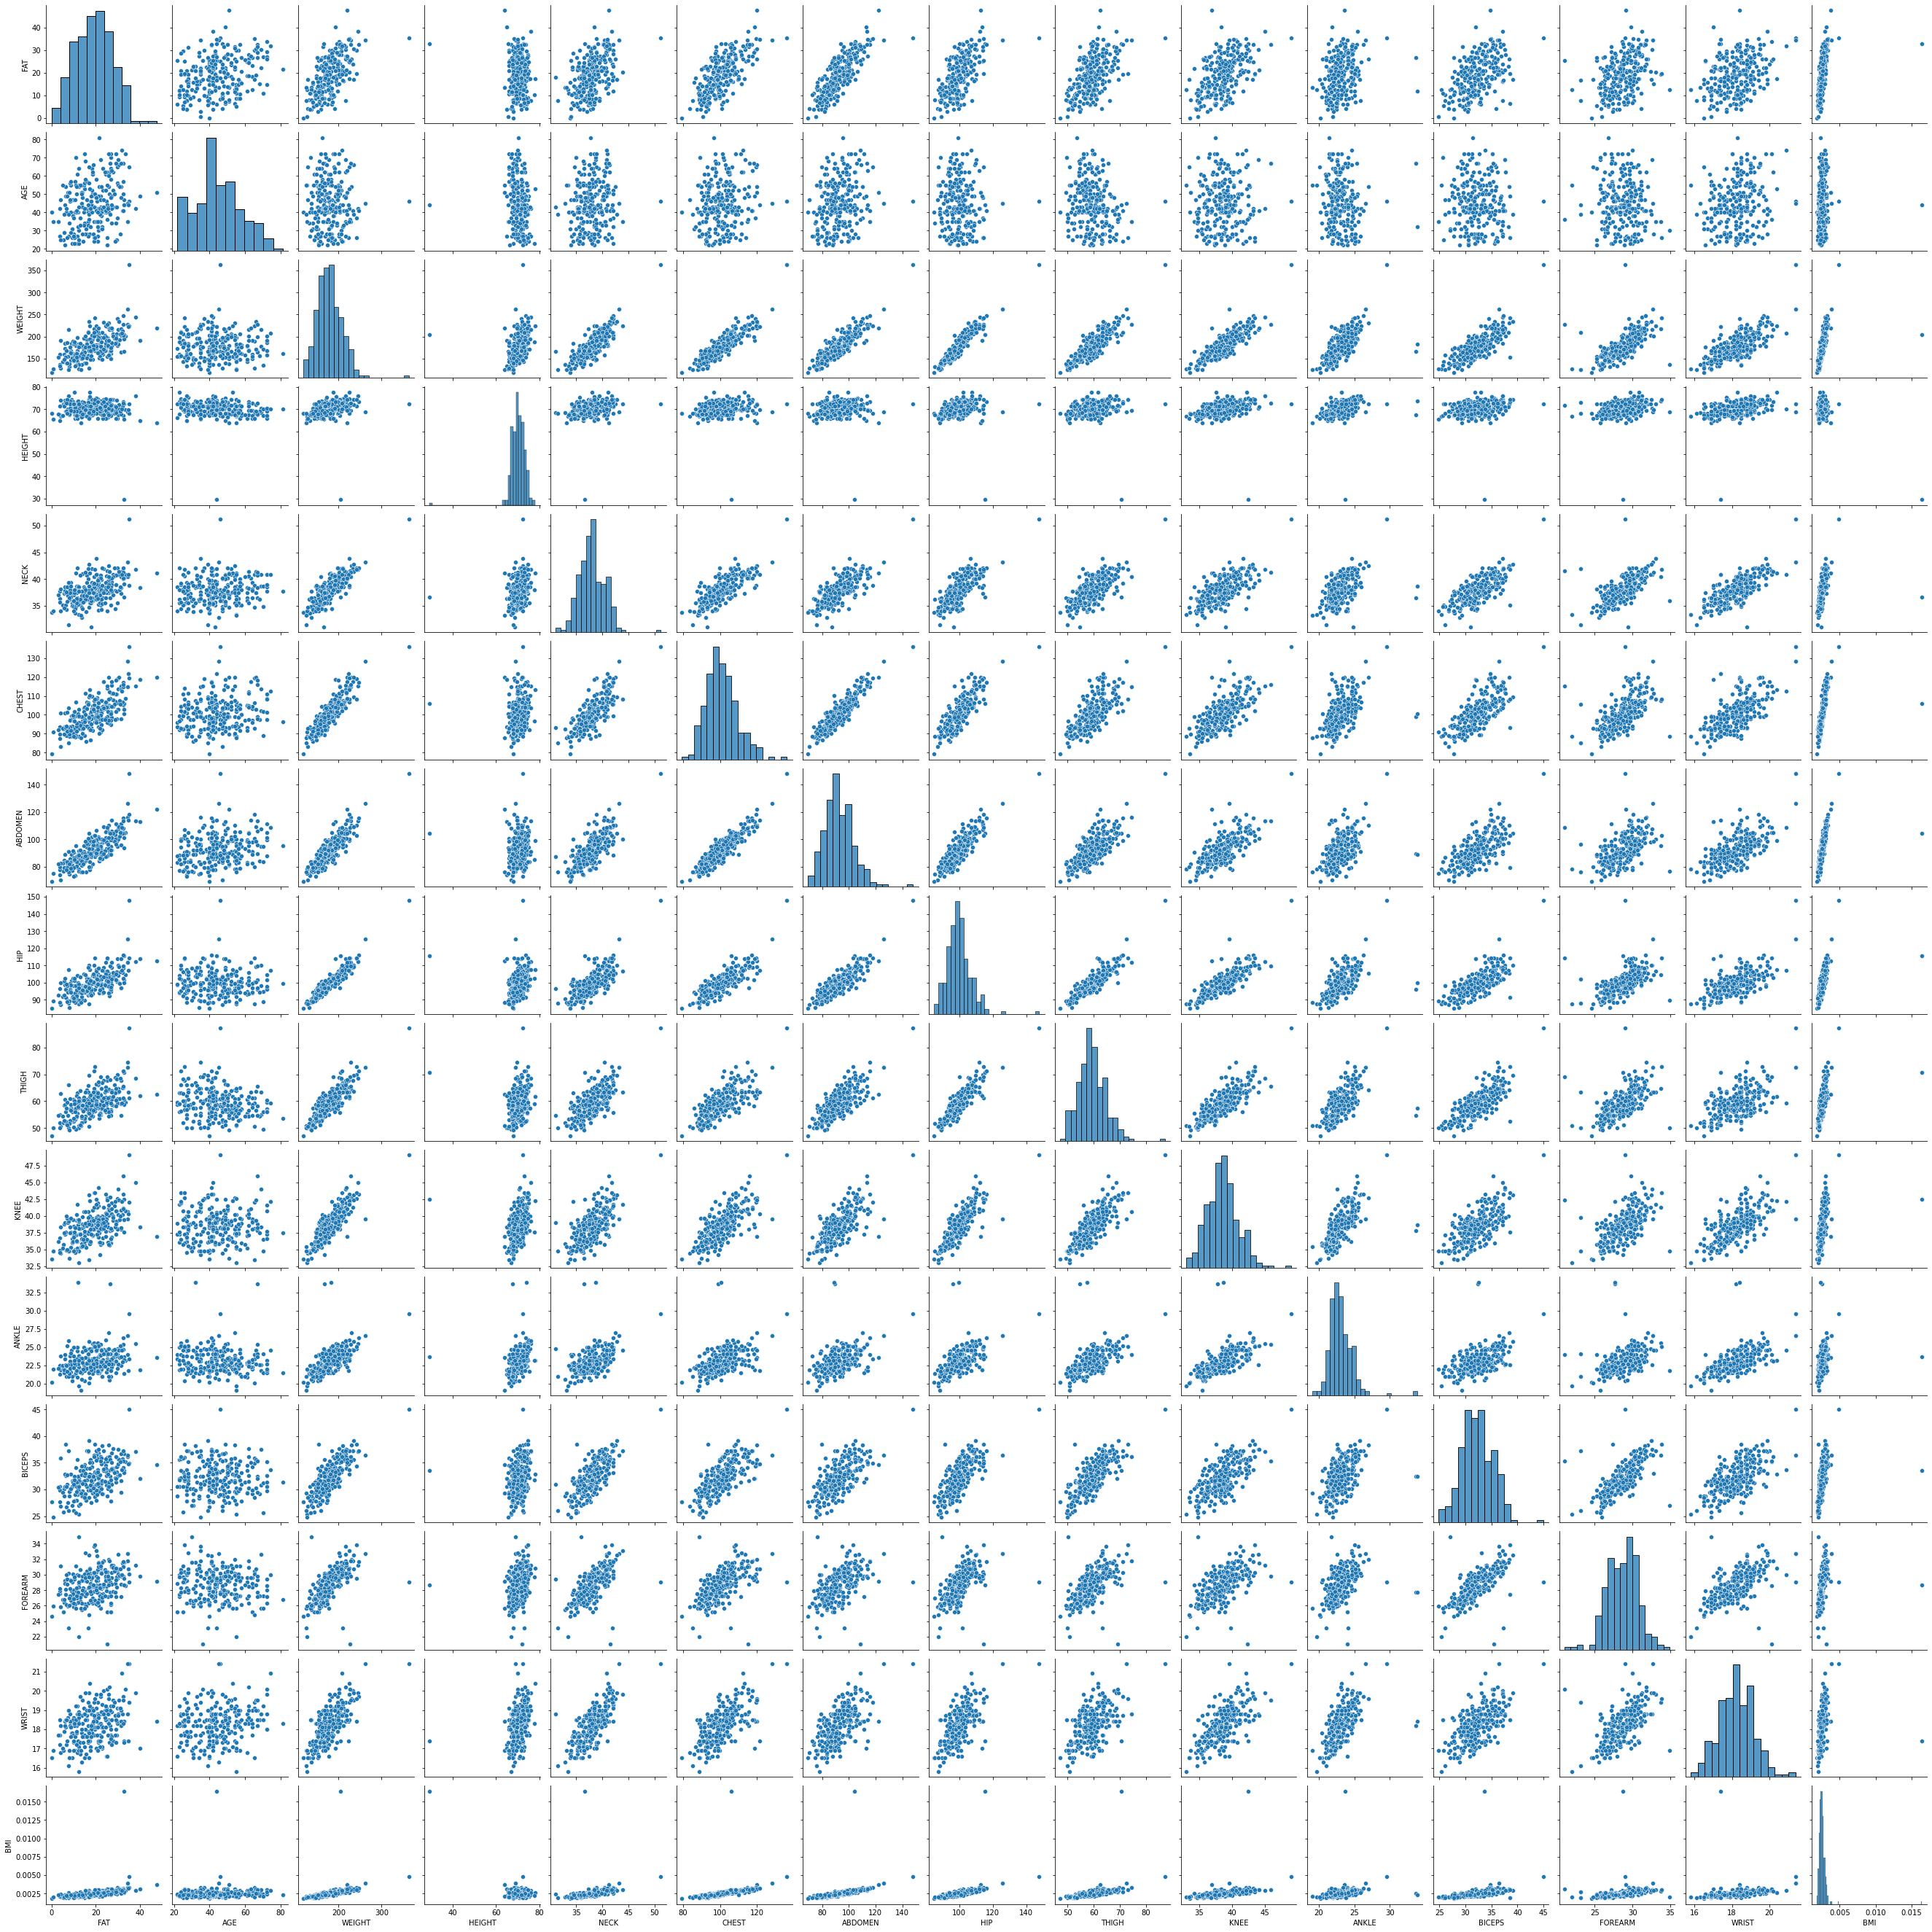

In [70]:
# 산점도 행렬을 통해서 목표변수와 설명변수의 분포를 시각적으로 파악한다.
sns.pairplot(df_body)

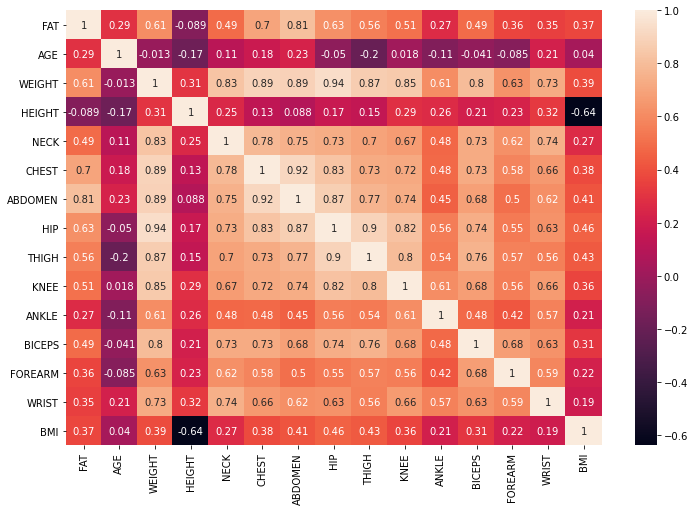

In [69]:
# 변수간의 상관관계를 파악한다.
plt.figure(figsize=(12,8))
g = sns.heatmap(df_body.corr(), annot=True)

# 스텝3 - 회귀 모델 생성: 설명변수 전체

In [75]:
reg_model = smf.ols(formula = 'FAT~AGE+WEIGHT+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST', data = df_body)

reg_result = reg_model.fit()
print(reg_result.summary())
# 전체 변수를 이용하여 회귀모델을 구성해보았을 때, 모형의 유의성 검정(F-test)은 p값이 7.72e-64로 유의수준 0.05에서 귀무가설을 기각한다.
# 따라서, 모든 회귀계수는 0이 아니라고 할 수있으며, 수정 회귀계수는 0.735의 값을 가진다.
# 앞으로 다중 공선성을 살펴본 뒤, 유의미한 독립변수를 추출하여 최종 회귀모형을 구해보도록 한다.

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           7.72e-64
Time:                        20:47:46   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.1885     17.349     -1.048      0.2

In [79]:
# 설명변수간의 다중 공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from statsmodels.api import qqplot, add_constant

df_x = df_body.drop('FAT', axis=1)
df_x_const = add_constant(df_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_x_const.values,i) for i in range(df_x_const.shape[1])]
                                                                # 두번째 인자는 디자인 매트리스의 인덱스
df_vif.sort_values('VIF', inplace=True)
df_vif.round(3)

# WEIGHT 변수의 VIF 값이 52로 가장 높다. 이 변수를 제거하고 다중 공선성을 다시 한 번 살펴보도록 한다.

,variable,VIF
10,ANKLE,1.922
12,FOREARM,2.196
1,AGE,2.251
13,WRIST,3.378
11,BICEPS,3.674
4,NECK,4.456
9,KNEE,4.815
14,BMI,7.432
8,THIGH,8.010
3,HEIGHT,9.146


In [81]:
df_x = df_body.drop(['FAT','WEIGHT'], axis=1)
df_x_const = add_constant(df_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_x_const.values,i) for i in range(df_x_const.shape[1])]
                                                                # 두번째 인자는 디자인 매트리스의 인덱스
df_vif.sort_values('VIF', inplace=True)
df_vif.round(3)

# HIP의 VIF값이 11.5로 가장 높다. 이 변수를 제거하고 다시 한 번 같은 과정을 반복해본다.

,variable,VIF
9,ANKLE,1.847
11,FOREARM,2.196
1,AGE,2.196
12,WRIST,3.327
10,BICEPS,3.507
3,NECK,3.962
2,HEIGHT,4.665
13,BMI,4.729
8,KNEE,4.788
7,THIGH,7.837


In [85]:
df_x = df_body.drop(['FAT','WEIGHT','HIP'], axis=1)
df_x_const = add_constant(df_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_x_const.values,i) for i in range(df_x_const.shape[1])]
                                                                # 두번째 인자는 디자인 매트리스의 인덱스
df_vif.sort_values('VIF', inplace=True)
df_vif.round(3)

# 다중 공선성을 처리한 뒤, 모든 변수에 대해서 VIF값이 10 미만임을 확인한다.
# 아래 리스트에 있는 변수들을 이용해 회귀모델을 적합하도록 한다.

,variable,VIF
8,ANKLE,1.844
1,AGE,2.125
10,FOREARM,2.168
11,WRIST,3.300
9,BICEPS,3.506
3,NECK,3.958
12,BMI,4.309
2,HEIGHT,4.380
7,KNEE,4.732
6,THIGH,6.380


# 스텝4 - 후진제거법을 통해 유의미하지 않은 변수 제거

# BMI추가한 뒤 다시하기

In [211]:
reg_model = smf.ols(formula = 'FAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST', data = df_body)

reg_result = reg_model.fit()
print(reg_result.summary())

# F검정시 p값은 1.80e-63로, 해당 모델의 회귀계수는 모두 0이 아니라고 할 수 있다.
# 개별 독립변수에 대한 t테스트 결과, x절편을 제외한 p값이 0.05이상이며, 가장 큰 ANKLE 변수를 제거한 뒤, 다시 한 번 모형을 적합해보도록 한다.

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     61.51
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           1.80e-63
Time:                        22:13:01   Log-Likelihood:                -723.60
No. Observations:                 252   AIC:                             1471.
Df Residuals:                     240   BIC:                             1514.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8402      7.370      0.114      0.9

In [87]:
reg_model = smf.ols(formula = 'FAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+THIGH+KNEE+BICEPS+FOREARM+WRIST', data = df_body)

reg_result = reg_model.fit()
print(reg_result.summary())

# 같은 방식으로, p값이 0.05이상이며, 가장 큰 THIGH변수를 제거한 뒤, 다시 한번 모형을 적합한다.

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     67.91
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           2.24e-64
Time:                        20:54:34   Log-Likelihood:                -723.65
No. Observations:                 252   AIC:                             1469.
Df Residuals:                     241   BIC:                             1508.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9724      7.346      0.132      0.8

In [88]:
reg_model = smf.ols(formula = 'FAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+KNEE+BICEPS+FOREARM+WRIST', data = df_body)

reg_result = reg_model.fit()
print(reg_result.summary())

# 같은 방식으로 KNEE를 제거한다.

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     75.69
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           2.73e-65
Time:                        20:55:41   Log-Likelihood:                -723.75
No. Observations:                 252   AIC:                             1467.
Df Residuals:                     242   BIC:                             1503.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6714      7.148      0.234      0.8

In [89]:
reg_model = smf.ols(formula = 'FAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+BICEPS+FOREARM+WRIST', data = df_body)

reg_result = reg_model.fit()
print(reg_result.summary())

# BICEPS도 제거한다.

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     85.16
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           4.06e-66
Time:                        20:56:06   Log-Likelihood:                -724.11
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     243   BIC:                             1498.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2384      6.937      0.034      0.9

In [90]:
reg_model = smf.ols(formula = 'FAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+FOREARM+WRIST', data = df_body)

reg_result = reg_model.fit()
print(reg_result.summary())

# Chest또한 제거한다.

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     97.39
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           5.39e-67
Time:                        20:56:31   Log-Likelihood:                -724.44
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     244   BIC:                             1493.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4541      6.876     -0.066      0.9

In [91]:
reg_model = smf.ols(formula = 'FAT~AGE+HEIGHT+NECK+ABDOMEN+FOREARM+WRIST', data = df_body)

reg_result = reg_model.fit()
print(reg_result.summary())

# 마지막으로 HEIGHT를 제거하도록 한다.

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     113.4
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           8.55e-68
Time:                        20:56:57   Log-Likelihood:                -725.03
No. Observations:                 252   AIC:                             1464.
Df Residuals:                     245   BIC:                             1489.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5172      6.806     -0.223      0.8

In [92]:
reg_model = smf.ols(formula = 'FAT~AGE+NECK+ABDOMEN+FOREARM+WRIST', data = df_body)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     133.8
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           4.28e-68
Time:                        20:57:25   Log-Likelihood:                -726.90
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     246   BIC:                             1487.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.4083      5.808     -1.448      0.1

위의 회귀분석 결과표로부터 다음과 같은 사실들을 확인할 수 있다.
- F 검정의 p값은 4.28e-68로, 회귀계수들은 모두 0이 아니라고 할 수 있다.
- 위 회귀모형의 수정 설명계수는 0.726이다. 즉, 이 모형은 FAT변수에 대해 72.6% 정도의 설명력을 가진다.
- 개별 독립변수들에 대한 t 검정의 p값은 모두 0.05보다 작다. 즉, 모두 유의한 변수라고 할 수 있다.
- 더빈왓슨 통계량은 2.084로, 2에 가깝다. 즉, 잔차들간에 독립성이 있다고 할 수 있다.
- Omnibus와 Jarque-Bera 검정에서 p값은 각각 0.526, 0.549로 유의수준 0.05에서 귀무가설을 기각한다. 즉, 잔차들은 정규성을 가진다고 할 수 있다.  

위의 표로부터 잔차들간의 독립성과 정규성이 확인되었다. 그래프를 활용해서 이를 나타내보고, 추가적으로 등분산성에 대한 확인을 진행하도록 한다.

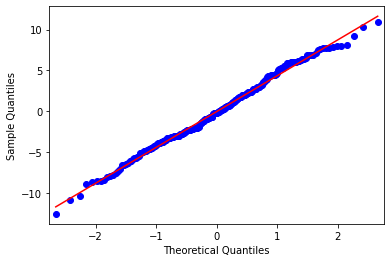

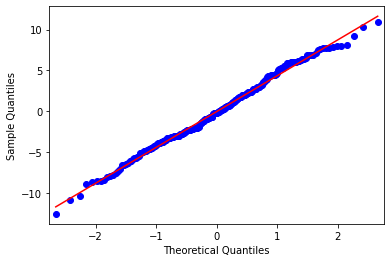

In [93]:
# 정규성 검정
qqplot(reg_result.resid, line='q')

# QQplot을 통해 잔차가 정규성을 가지는 것을 확인할 수 있다.

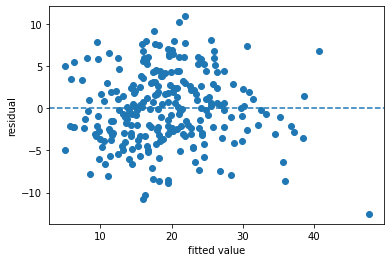

In [101]:
# 잔차의 등분산성 & 독립성
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel('fitted value'); plt.ylabel('residual')
plt.axhline(y = 0, linestyle = '--')

# 아래의 그래프를 통해 잔차들이 일정한 경향을 보이지 않음을 알 수 있다. 즉, 독립성과 등분산성을 가지는 것을 확인할 수 있다.

# 문제2 - 의사결정나무(예측)

콘크리트 강도를 예측하는 의사결정나무 모델을 만들고 predict method를
이용하여 예측값을 구하라. 그리고 모델의 mse와 mae를 산출하여 비교하라.

In [207]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [183]:
df_concrete = pd.read_csv(path + 'Concrete.csv')
X = df_concrete.drop('CONCRETE_COMPRESSIVE_STRENGTH', axis=1)
Y = df_concrete['CONCRETE_COMPRESSIVE_STRENGTH']

In [184]:
trainX, testX, trainY, testY = train_test_split(X,Y,test_size = 0.3, random_state=1234)

In [185]:
trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size = 0.42, random_state = 1234)

In [187]:
print('Training X: ',trainX.shape)
print('Training Y: ',trainY.shape)

print('Validation X: ',validX.shape)
print('Validation Y: ',validY.shape)

print('Test X: ',testX.shape)
print('Test Y: ',testY.shape)

Training X:  (418, 8)
Training Y:  (418,)
Validation X:  (303, 8)
Validation Y:  (303,)
Test X:  (309, 8)
Test Y:  (309,)


In [188]:
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(trainX,trainY)

DecisionTreeRegressor(random_state=1234)

In [190]:
print('Score on training set:{:.3f}'.format(tree_uncustomized.score(trainX,trainY)))
print('Score on validation set:{:.3f}'.format(tree_uncustomized.score(validX,validY)))

Score on training set:1.000
Score on validation set:0.690


#### Grid Search를 통해서 최적의 파라미터를 탐색해보도록 한다.

In [230]:
pd.concat(trainX,validX)

AttributeError: 'DataFrame' object has no attribute 'concat'

In [224]:
cv = KFold(n_splits=5)

para_depth = [depth for depth in range(2,18)]
para_split = [n_split*2 for n_split in range(2,20)]
para_leaf = [n_leaf for n_leaf in range(2,20)]

estimator = DecisionTreeRegressor(random_state = 1234)
param_grid = {'criterion':['mse','mae'],\
              'max_depth':para_depth,'min_samples_split':para_split,\
              'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring='r2', n_jobs=-1, cv=cv)
grid_dt.fit(trainX,trainY)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeRegressor(random_state=1234), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [4, 6, 8, 10, 12, 14, 16, 18, 20,
                                               22, 24, 26, 28, 30, 32, 34, 36,
                                               38]},
             scoring='r2')

In [225]:
print('best estimator model: \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print('\nbest score: \n{}'.format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeRegressor(max_depth=11, min_samples_leaf=2, min_samples_split=8,
                      random_state=1234)

best parameter: 
{'criterion': 'mse', 'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 8}

best score: 
0.797


In [1]:
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

!apt-get install -y fonts-nanum
!ls -l /usr/share/fonts/truetype/
!rm -rf ~/.cache/matplotlib/*
!fc-cache -fv
plt.rc('font', family='Malgun Gothic')

# from statsmodels.formula.api import ols
# from statsmodels.api import qqplot, add_constant
# import statsmodels.formula.api as smf
# from statsmodels.tools.eval_measures import rmse
# %matplotlib inline

# from matplotlib import font_manager, rc
# plt.rc('font', family='Malgun Gothic')
# plt.rcParams["font.family"] = 'NanumGothic'


E: 잠금 파일 /var/lib/dpkg/lock-frontend 파일을 열 수 없습니다 - open (13: 허가 거부)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
합계 188
drwxr-xr-x 2 root root 4096  2월  4  2020 Gargi
drwxr-xr-x 2 root root 4096  2월  4  2020 Gubbi
drwxr-xr-x 2 root root 4096  2월  4  2020 Nakula
drwxr-xr-x 2 root root 4096  2월  4  2020 Navilu
drwxr-xr-x 2 root root 4096  2월  4  2020 Sahadeva
drwxr-xr-x 2 root root 4096  2월  4  2020 Sarai
drwxr-xr-x 2 root root 4096  2월  4  2020 abyssinica
drwxr-xr-x 2 root root 4096 11월 12 19:45 dejavu
drwxr-xr-x 2 root root 4096  2월  4  2020 droid
drwxr-xr-x 2 root root 4096 11월  9 14:53 elusive-icons
drwxr-xr-x 2 root root 4096 11월  9 14:53 font-awesome
drwxr-xr-x 2 root root 4096  2월  4  2020 fonts-beng-extra
drwxr-xr-x 2 root root 4096  2월  4  2020 fonts-deva-extra
drwxr-xr-x 2 root root 4096  2월  4  2020 fonts-gujr-extra
drwxr-xr-x 2 root root 4096  2월  4  2020 fonts-guru-extra
drwxr-xr-x 2 root root 4096  2월  4  2020 fonts-kalapi
drwxr-

/usr/share/fonts/type1/gsfonts: caching, new cache contents: 35 fonts, 0 dirs
/usr/share/fonts/woff: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/woff/elusive-icons: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/woff/font-awesome: caching, new cache contents: 1 fonts, 0 dirs
/home/piai/anaconda3/fonts: skipping, no such directory
/home/piai/.local/share/fonts: skipping, no such directory
/home/piai/.fonts: skipping, no such directory
/usr/share/fonts/X11: skipping, looped directory detected
/usr/share/fonts/cMap: skipping, looped directory detected
/usr/share/fonts/cmap: skipping, looped directory detected
/usr/share/fonts/eot: skipping, looped directory detected
/usr/share/fonts/opentype: skipping, looped directory detected
/usr/share/fonts/svg: skipping, looped directory detected
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/type1: skipping, looped directory detected
/usr/share/fonts/woff: skipping, looped directory d

# 1) 의사결정나무 실습

In [11]:
path = '/home/piai/Downloads/big_data/'

In [12]:
# 스텝1 패키지 불러오기
import pandas as pd
import matplotlib
from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [13]:
df_raw = pd.read_csv(path + 'DIABETES.csv')

In [14]:
df_raw_y = df_raw['Y']
df_raw_x = df_raw.drop('Y', axis=1, inplace = False)

In [15]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y,\
                                                                test_size = 0.3, random_state = 1234)

# 2) 의사결정나무 모델 생성

In [16]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set:{:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))
print('Score on training set:{:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set:1.000
Score on training set:-0.143


In [17]:
tree_uncustomized

DecisionTreeRegressor(random_state=1234)

In [18]:
train_score, test_score = [], []

para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 1234,\
                                 min_samples_leaf = v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [19]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,-0.143
1,2,0.953,-0.111
2,3,0.878,0.039
3,4,0.836,0.083
4,5,0.773,0.062
5,6,0.730,0.042
6,7,0.707,0.107
7,8,0.669,0.109
8,9,0.649,0.144
9,10,0.614,0.203


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


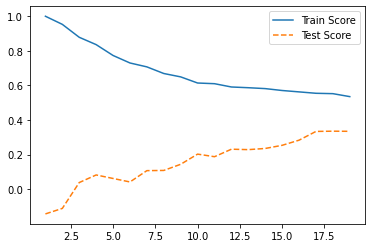

In [20]:
plt.plot(para_leaf, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

### 잎사귀 노드 최소 자류 수 증가에 따라 모델의 설명력은 감소
### Train/test 데이터의 성능 변화를 고려하여 4 선택.
### test 데이터의 성능 변화를 고려하면 17도 가능하나 train데이터의 성능이 많이 저하된다.

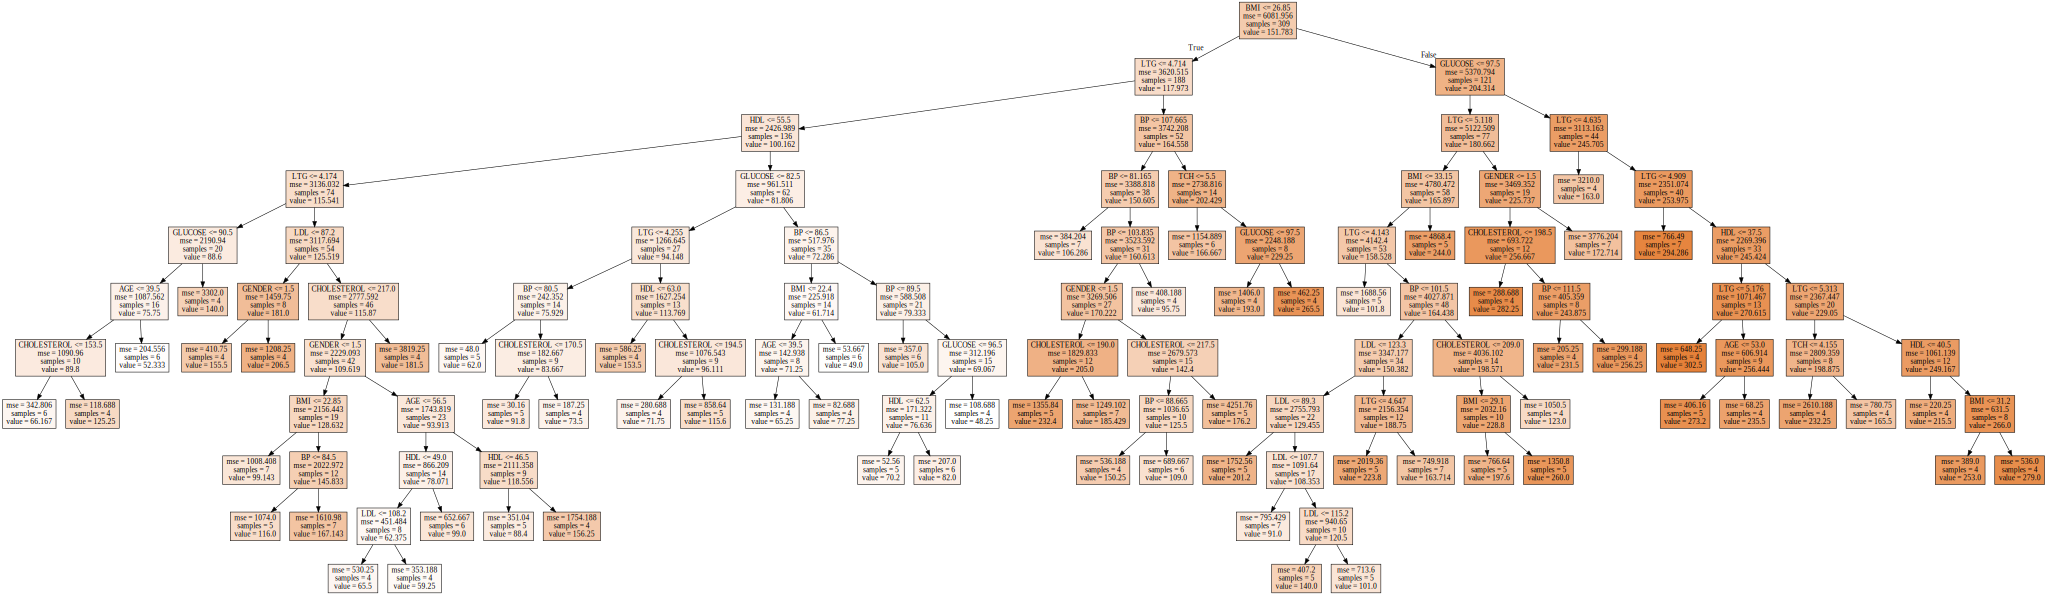

In [24]:
v_feature_name = df_train_x.columns

tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=4)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = 'tree_leaf.dot',
                feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_leaf.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

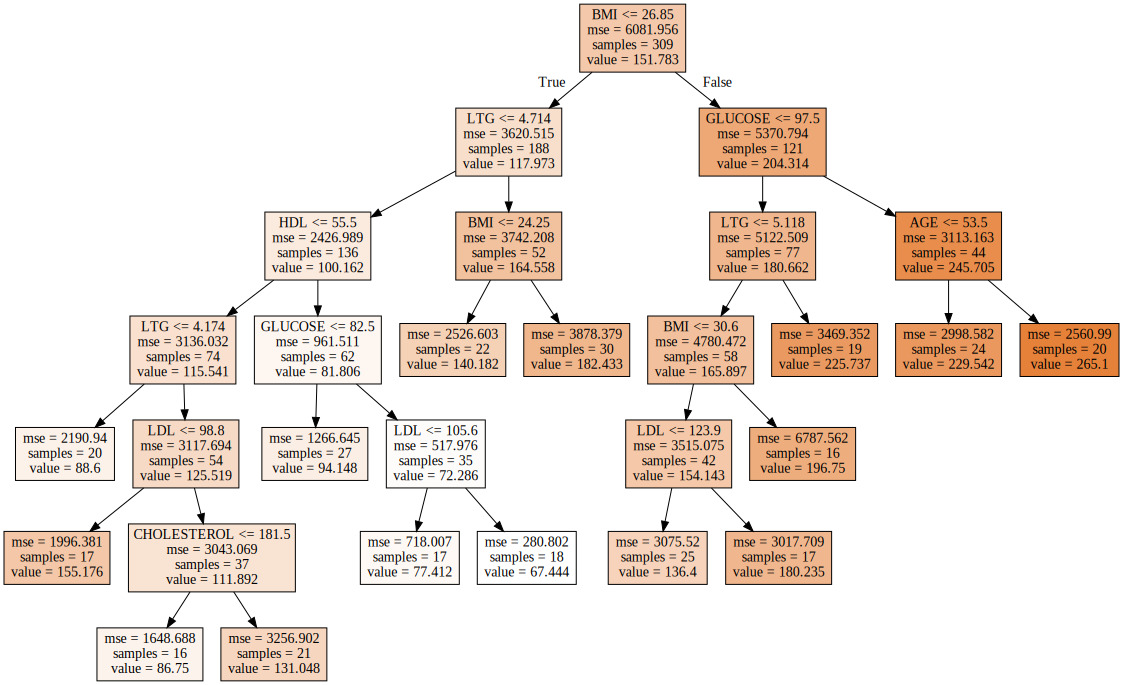

In [22]:
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=17)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file='tree_leaf.dot',\
feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_leaf.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [28]:
train_score = []; test_score = []
para_split = [n_split*2 for n_split in range(2,20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=4,\
                                min_samples_split=v_min_samples_split)
    tree.fit(df_train_x,  df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSamplesLeaf'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

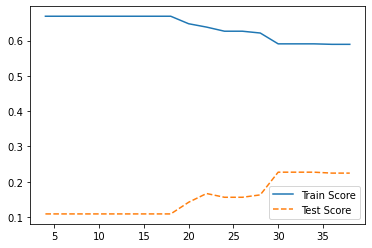

In [30]:
df_score_split.round(3)
plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

### 분리 노드의 최소 자류 수 증가에 따라 모델의 설명력은 감소
### Train/test 데이터의 성능 변화를 고려하여 30선택

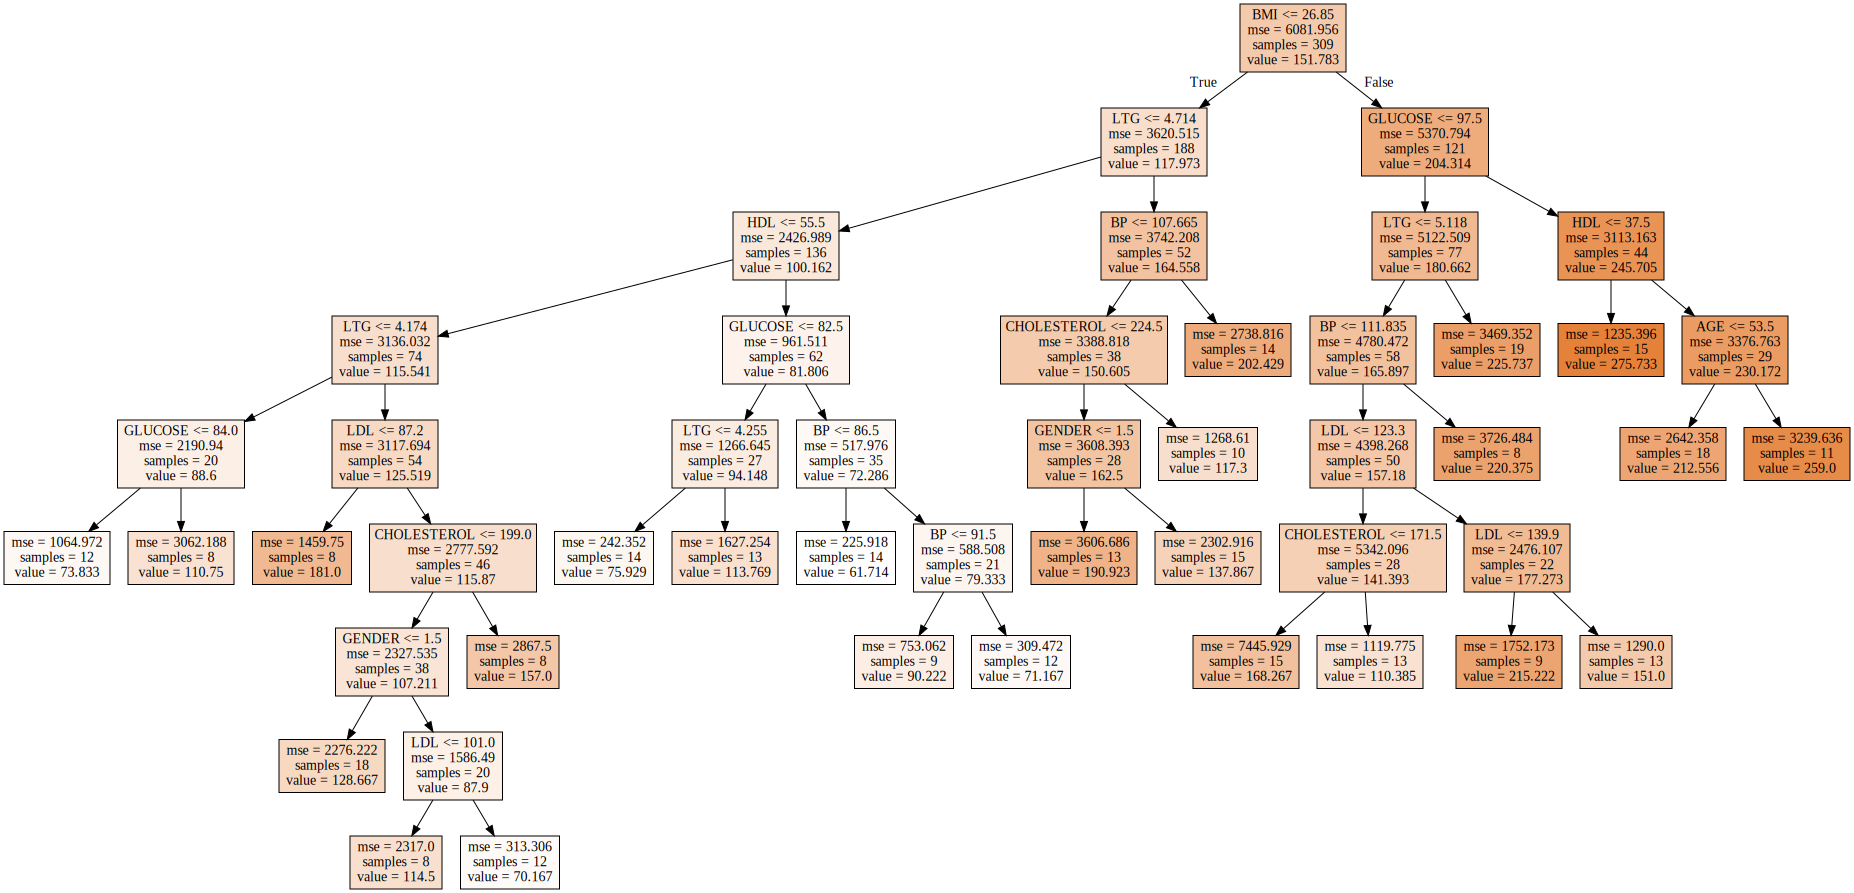

In [32]:
# 분리 노드의 최소 자료 수 = 26 모델
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf = 4, min_samples_split=30)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file='tree_split.dot',\
feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_split.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# depth

In [42]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=8,\
                                min_samples_split=20, max_depth = v_max_depth)
    tree.fit(df_train_x,  df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

In [43]:
df_score_depth

,Depth,TrainScore,TestScore
0,1,0.292021,0.230966
1,2,0.438055,0.351044
2,3,0.511292,0.278809
3,4,0.556256,0.263937
4,5,0.600513,0.199242
5,6,0.634311,0.156564
6,7,0.642689,0.146348
7,8,0.647709,0.141716
8,9,0.647709,0.141716
9,10,0.647709,0.141716


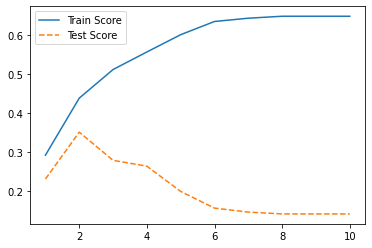

In [44]:
df_score_depth.round(3)
plt.plot(para_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

### 최대 깊이 증가에 따라 모델의 설명력은 증가
### train/test 데이터의 성능 변화를 고려하여 3 선택

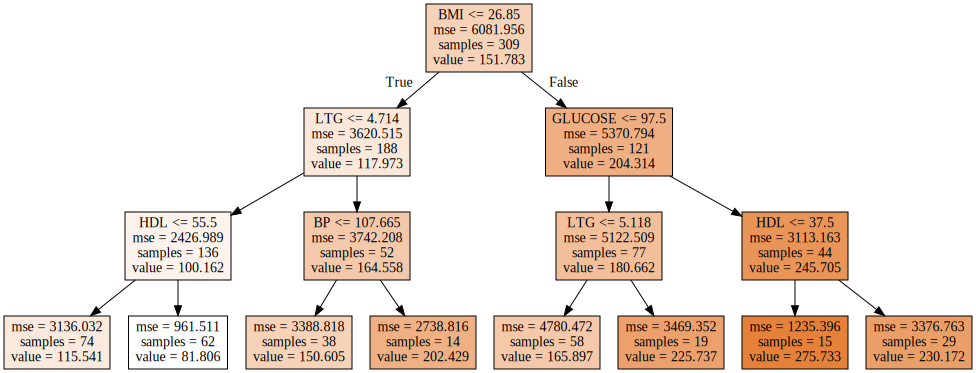

In [103]:
# 최대 깊이 = 3 모델
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf = 8, min_samples_split=20, max_depth=3)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file='tree_depth.dot',\
feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_depth.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 11/17 - 직전까지 하고 중단

In [25]:
# step2 - 모델 파라미터 조정
train_score = []; test_score = []
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x,  df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [14]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,-0.143
1,2,0.953,-0.111
2,3,0.878,0.039
3,4,0.836,0.083
4,5,0.773,0.062
5,6,0.730,0.042
6,7,0.707,0.107
7,8,0.669,0.109
8,9,0.649,0.144
9,10,0.614,0.203


In [15]:
tree_final = DecisionTreeRegressor(min_samples_leaf = 8, min_samples_split = 20, max_depth = 4, random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=8, min_samples_split=20,
                      random_state=1234)

In [16]:
export_graphviz(tree_final, out_file='tree_final.dot', feature_names = v_feature_name, impurity = True, filled = True)

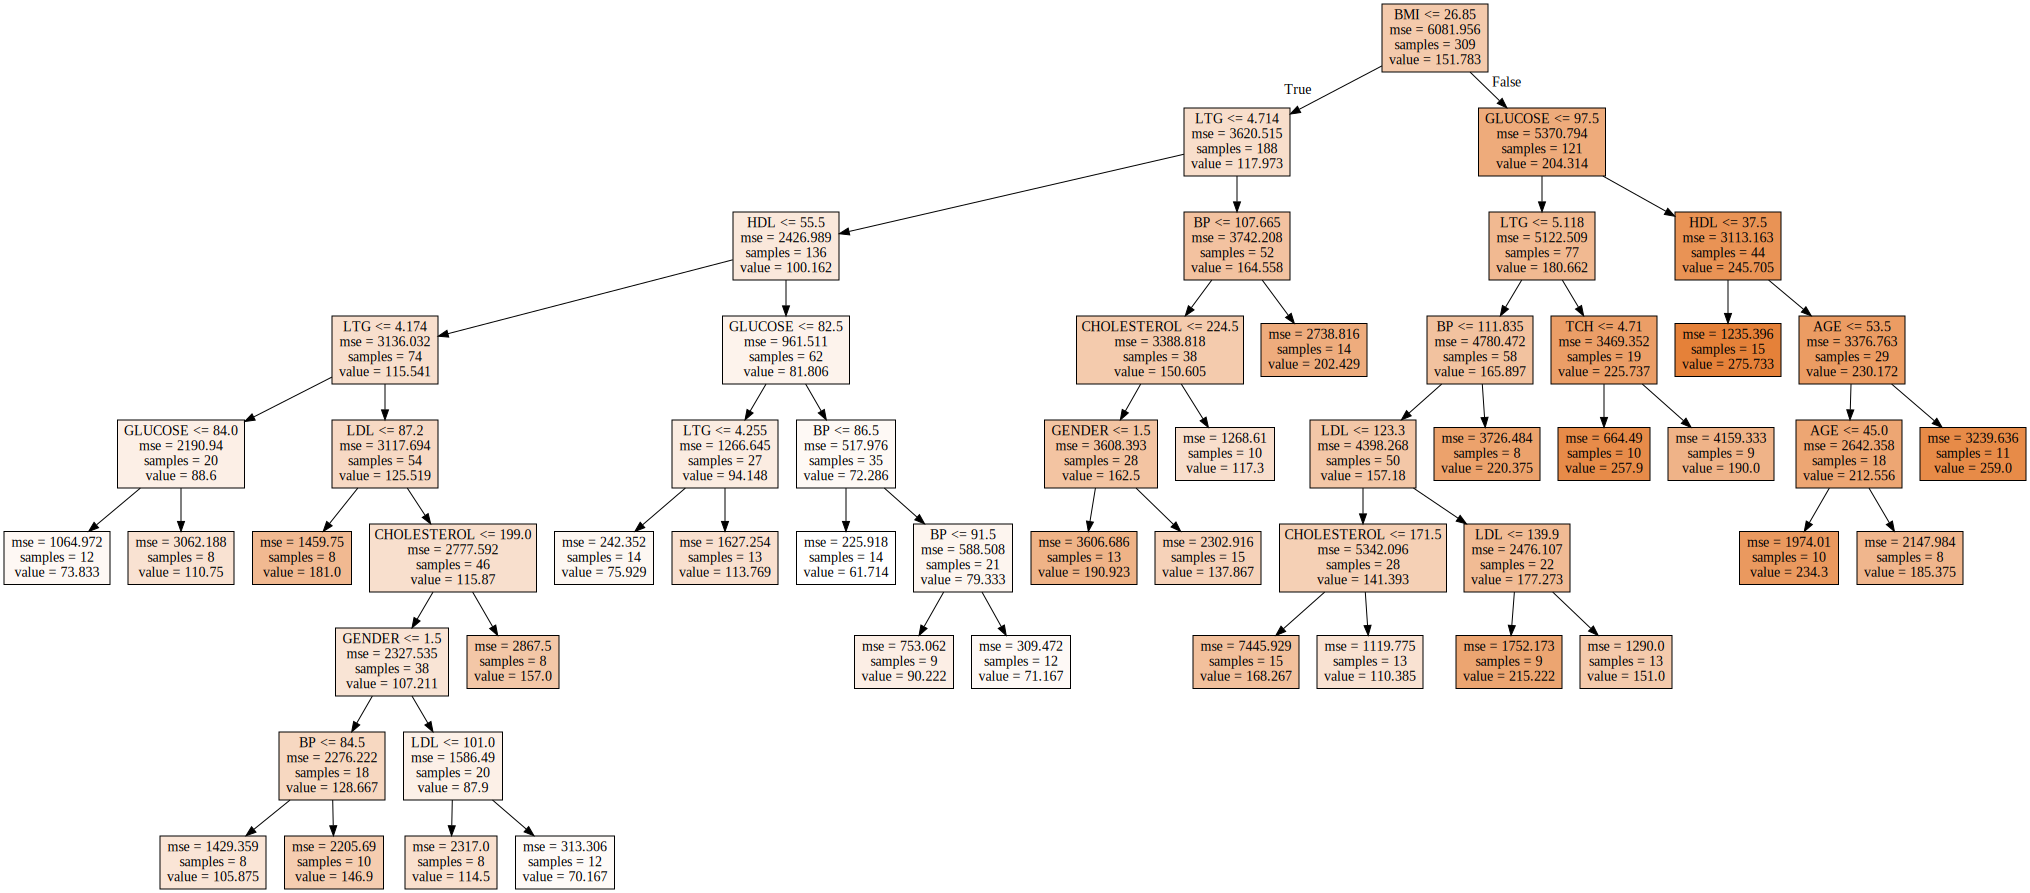

In [17]:
display(graphviz.Source(dot_graph))

In [18]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace =True)
df_importance.round(3)

,Feature,Importance
2,BMI,0.525
8,LTG,0.217
9,GLUCOSE,0.120
6,HDL,0.056
3,BP,0.053
4,CHOLESTEROL,0.014
0,AGE,0.014
1,GENDER,0.000
5,LDL,0.000
7,TCH,0.000


Text(0, 0.5, '변수')

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: Runtim

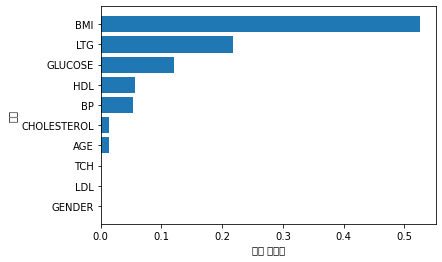

In [19]:
df_importance.sort_values('Importance', ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [20]:
para_depth = [depth for depth in range(1,11)]


estimator = DecisionTreeRegressor()
param_grid = {'criterion':['mse','friedman_mse','mae'],'max_features':['auto','sqrt','log2'],
             'max_depth':para_depth,'min_samples_split': para_split,
             'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring='r2', n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)


best score: 
0.412


In [236]:
print('\nbest parameter:\n{}'.format(grid_dt.best_params_))
print('\nbest score: \n{}'.format(grid_dt.best_score_.round(3)))


best parameter:
{'criterion': 'mae', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 18, 'min_samples_split': 4}


In [ ]:
!apt-get install -y fonts-nanum

In [ ]:
!ls -l /usr/share/fonts/truetype/